# Credit Momentum

Societe Generale: Trend-following and mean-reversion strategies on credit indices

## Packages

In [4]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [5]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CreditMomentum/root/src")
from SignalGenerator import SignalGenerator

## Get Data

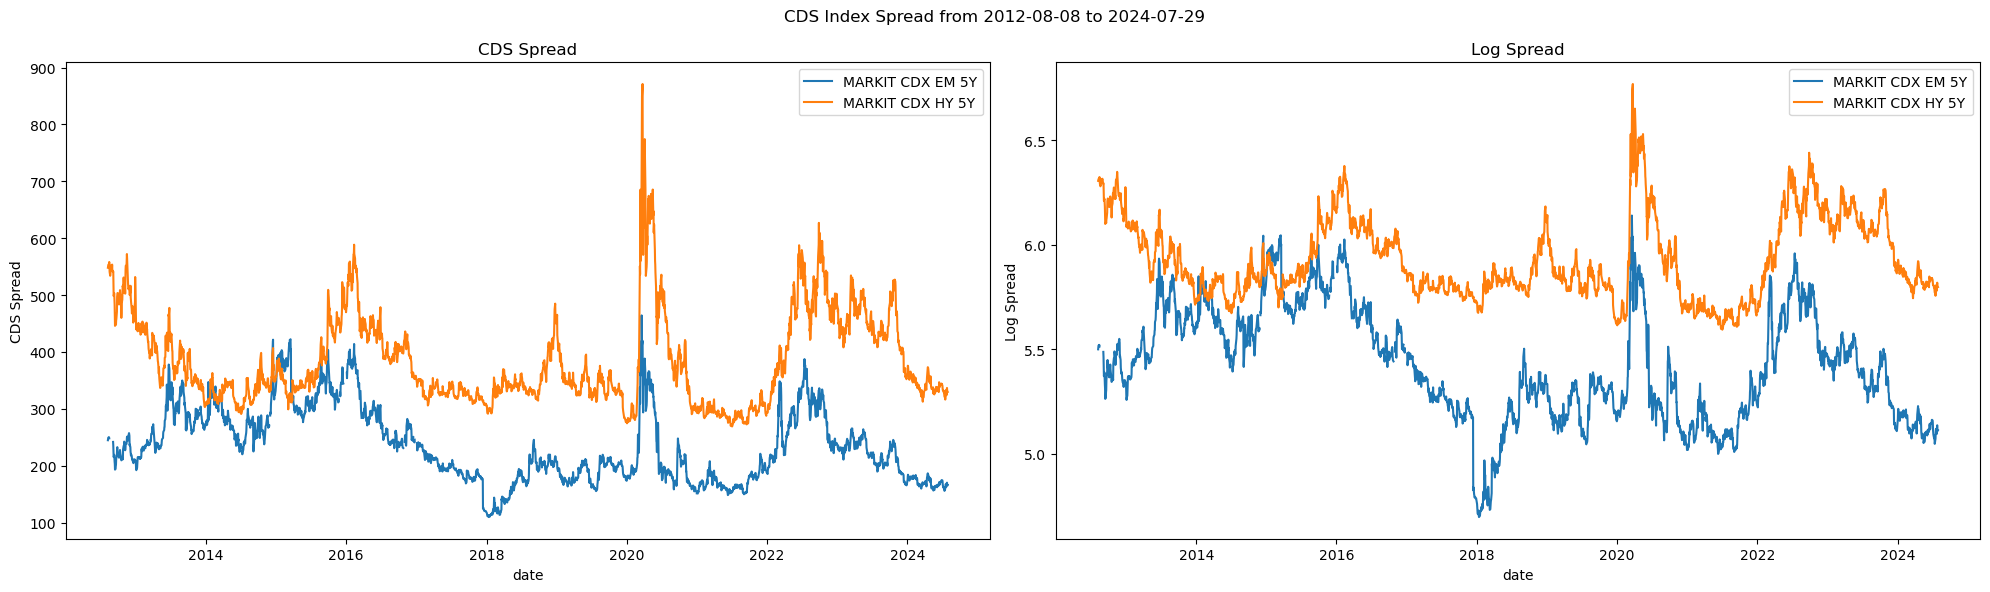

In [7]:
def plot_spread() -> plt.Figure: 

    df_longer = (SignalGenerator().get_cds().query(
        "variable == 'SPRD'").
        drop(columns = ["variable", "maturity"]).
        assign(log_val = lambda x: np.log(x.value)).
        rename(columns = {"value": "spread"}).
        melt(id_vars = ["date", "unique_name"]))
    
    variables = df_longer.variable.drop_duplicates().to_list()
    renamer = {
        "spread" : "CDS Spread",
        "log_val": "Log Spread"}
    
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_longer.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            rename(columns = {"unique_name": ""}).
            pivot(index = "date", columns = "", values = "value").
            plot(
                ax     = ax,
                ylabel = renamer[variable],
                title  = renamer[variable]))
    
    fig.suptitle("CDS Index Spread from {} to {}".format(
        df_longer.date.min(),
        df_longer.date.max()))

    plt.tight_layout()

plot_spread()

## Trend Following Strategy

In [9]:
def get_trend_rtn() -> pd.DataFrame: 

    df_tmp = (SignalGenerator().get_kalman_ewma_signal().drop(
        columns = ["value", "trend_signal"]).
        rename(columns = {"variable": "kalman_var"}).
        merge(right = SignalGenerator().get_cds_rtn(), how = "inner", on = ["date", "unique_name"]).
        assign(
            signal_pnl = lambda x: -1 * np.sign(x.lag_signal) * x.px_diff,
            signal_rtn = lambda x: -1 * np.sign(x.lag_signal) * x.px_rtn,
            tmp_name   = lambda x: np.where(x.signal_name == 20, "1 Month", "3 Month"),
            strat_name = lambda x: x.unique_name.str.split("CDX").str[1].str.strip() + " " + x.tmp_name))

    return df_tmp

df_trend = get_trend_rtn()

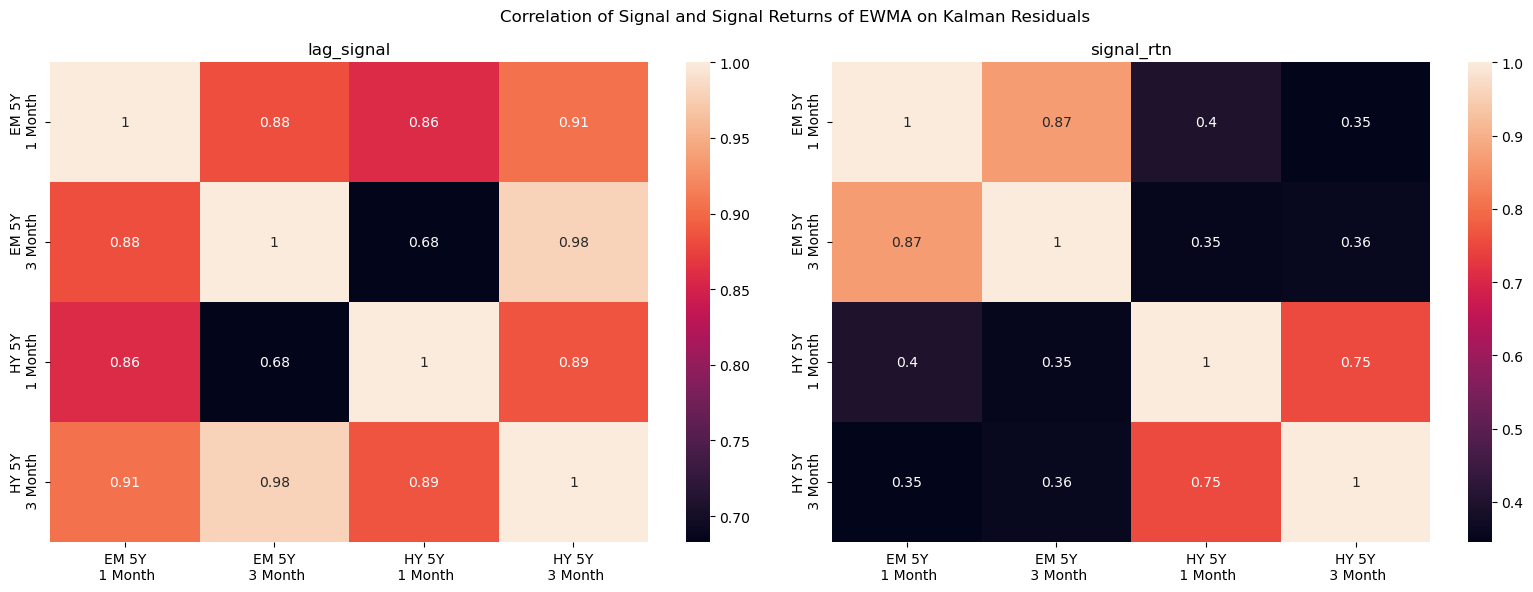

In [10]:
def plot_correlation(df_trend: pd.DataFrame) -> plt.Figure: 

    df_longer = (df_trend[
        ["date", "strat_name", "lag_signal", "signal_rtn"]].
        melt(id_vars = ["date", "strat_name"]))
    
    variables = df_longer.variable.drop_duplicates().to_list()
    renamer = {
        "lag_signal": "Signal",
        "signal_rtn": "Signal Return"}
    
    fig, axes = plt.subplots(ncols = len(variables), figsize = (16,6))
    
    for signal, ax in zip(variables, axes.flatten()):
    
        df_corr = (df_longer.query(
            "variable == @signal").
            drop(columns = ["variable"]).
            assign(strat_name = lambda x: x.strat_name.str.replace("5Y", "5Y\n")).
            pivot(index = "date", columns = "strat_name", values = "value").
            corr())
    
        sns.heatmap(
            data   = df_corr,
            annot  = True,
            ax     = ax)
    
        ax.set_xlabel(""); ax.set_ylabel("")
        ax.set_title(signal)
    
    fig.suptitle("Correlation of Signal and Signal Returns of EWMA on Kalman Residuals")
    plt.tight_layout()

plot_correlation(df_trend)

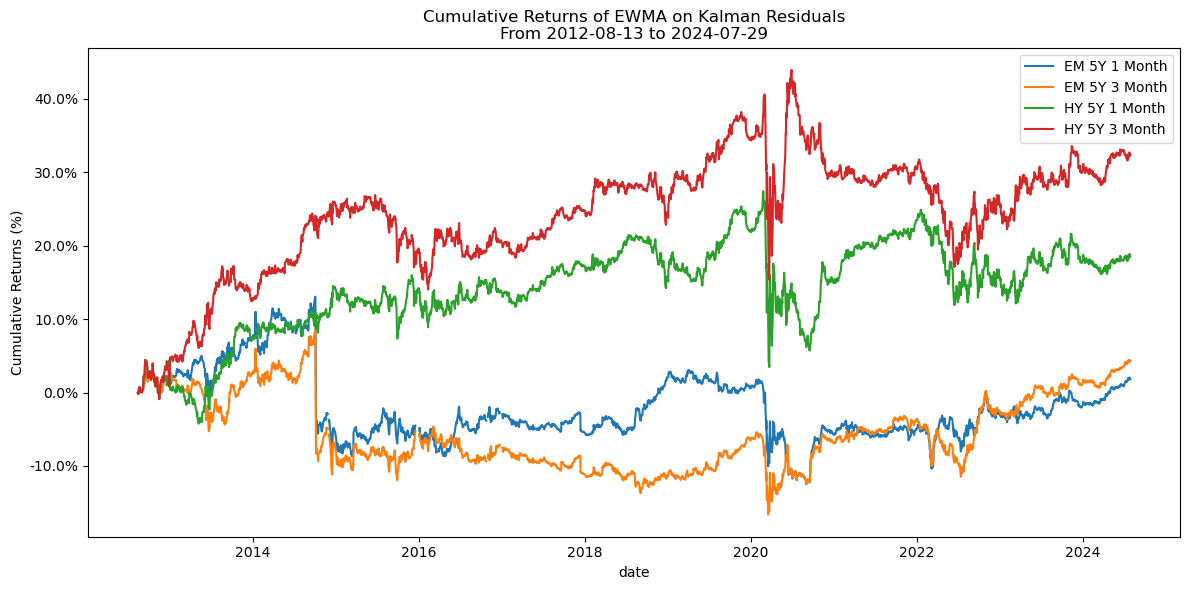

In [11]:
def plot_cdx_trend(df_trend: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    (df_trend[
        ["date", "strat_name", "signal_rtn"]].
        rename(columns = {"strat_name": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax      = axes,
            ylabel  = "Cumulative Returns (%)",
            title   = "Cumulative Returns of EWMA on Kalman Residuals\nFrom {} to {}".format(
                df_trend.date.min(),
                df_trend.date.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
    plt.tight_layout()

plot_cdx_trend(df_trend)

In [12]:
def get_sharpe(df_trend: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe_tmp = (df_trend[
        ["unique_name", "tmp_name", "signal_rtn"]].
        groupby(["unique_name", "tmp_name"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["unique_name", "tmp_name", "sharpe"]])
    
    df_original = (SignalGenerator().get_cds_rtn()[
        ["unique_name", "px_rtn"]].
        groupby("unique_name").
        agg(["mean", "std"])
        ["px_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn).
        reset_index()
        [["unique_name", "sharpe"]].
        assign(tmp_name = "No Signal"))
    
    df_combined = (pd.concat(
        [df_sharpe_tmp, df_original]))


    return df_combined

df_sharpe = get_sharpe(df_trend)

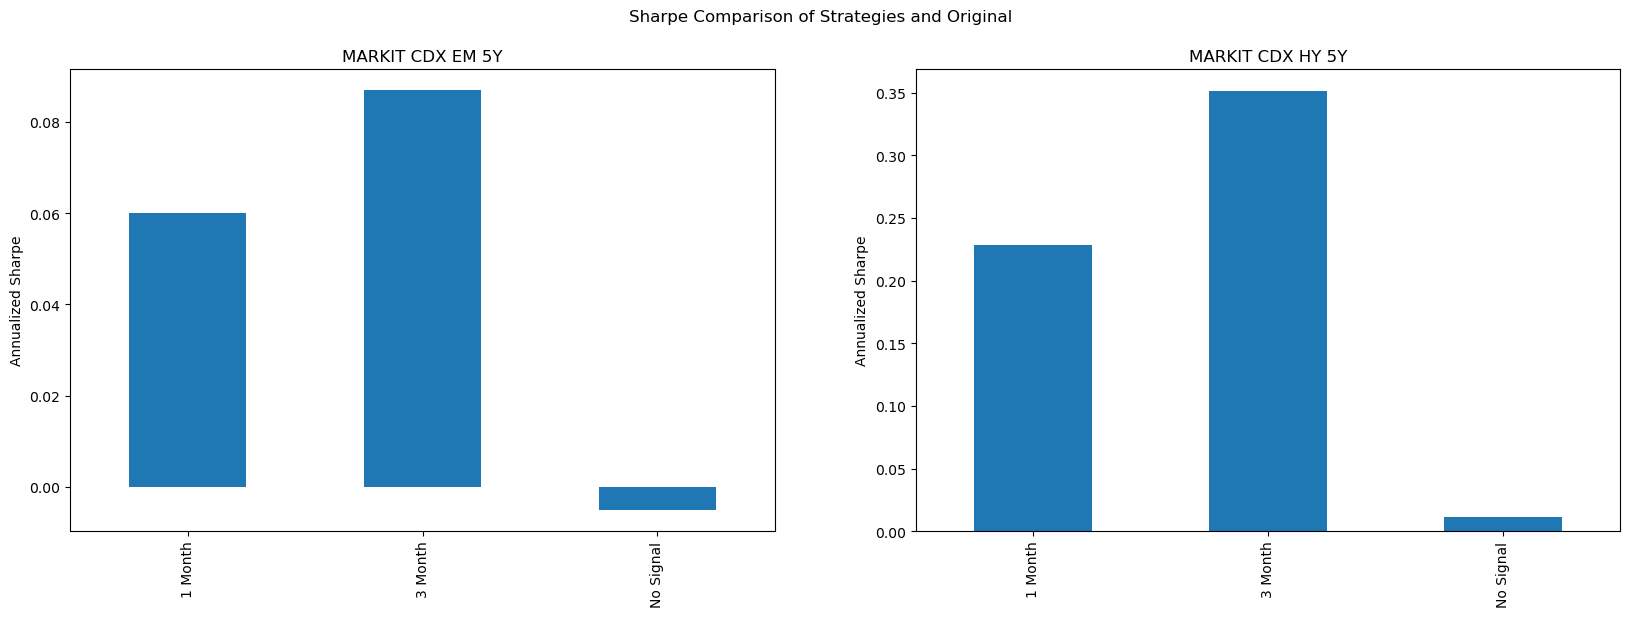

In [13]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    variables = df_sharpe.unique_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        (df_sharpe.query(
            "unique_name == @variable").
            set_index("tmp_name").
            sort_index().
            plot(
                ax     = ax,
                kind   = "bar",
                legend = False,
                xlabel = "",
                ylabel = "Annualized Sharpe",
                title  = variable))
    
    fig.suptitle("Sharpe Comparison of Strategies and Original")
    
plot_sharpe(df_sharpe)

Now create 3 optimization strateiges <br>
1. Equal Risk Contribution across all strategies
2. Equal Risk Contribution across each security
3. Equal Risk Contribution across each lookback window

In [15]:
def _get_vol(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(
            vol     = lambda x: x.signal_rtn.rolling(window = window).std(),
            lag_vol = lambda x: x.vol.shift(),
            inv_vol = lambda x: 1 / x.lag_vol))

    return df_out

def get_vol(df_trend: pd.DataFrame, window: int = 30) -> pd.DataFrame: 
    
    df_out = (df_trend[
        ["date", "unique_name", "signal_name", "signal_rtn", "strat_name"]].
        groupby("strat_name").
        apply(_get_vol, window, include_groups = False).
        reset_index(drop = True).
        dropna())

    return df_out

df_vol = get_vol(df_trend)

In [16]:
def get_full_erc(df_vol: pd.DataFrame) -> pd.DataFrame: 

    df_full = (df_vol[
        ["date", "inv_vol"]].
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_vol, how = "inner", on = "date").
        assign(weight_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn)
        [["date", "weight_rtn"]].
        groupby("date").
        agg("sum"))

    return df_full

df_full_erc = get_full_erc(df_vol)

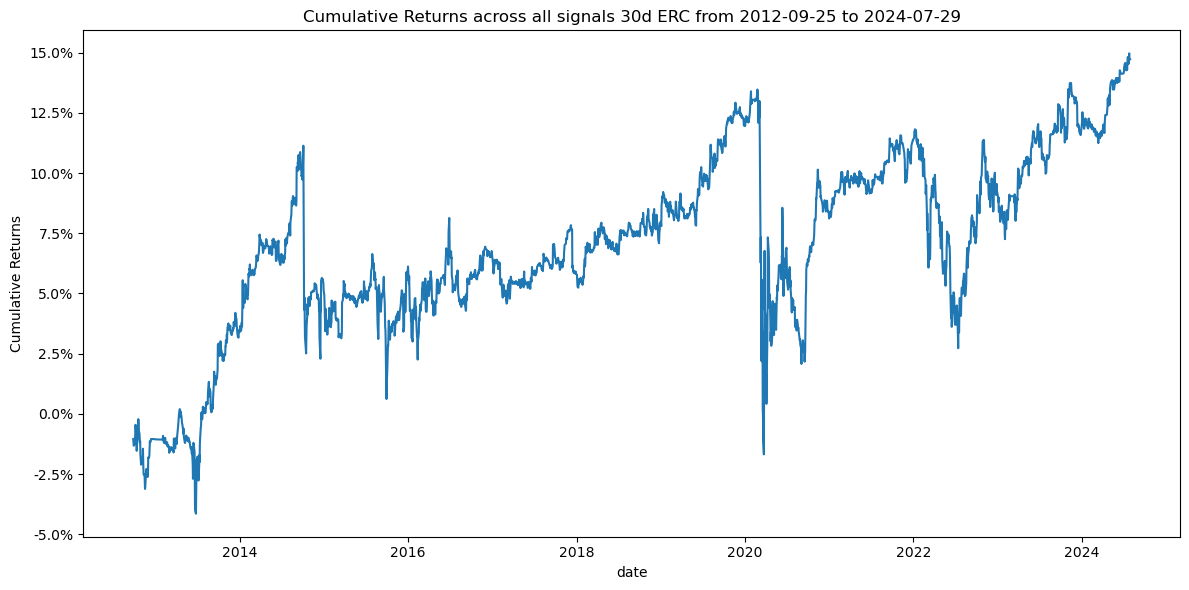

In [17]:
def plot_erc_portfolio(df_full_erc: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_full_erc.apply(
        lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            legend = False,
            ylabel = "Cumulative Returns",
            title  = "Cumulative Returns across all signals 30d ERC from {} to {}".format(
                df_full_erc.index.min(),
                df_full_erc.index.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
    plt.tight_layout()

plot_erc_portfolio(df_full_erc)

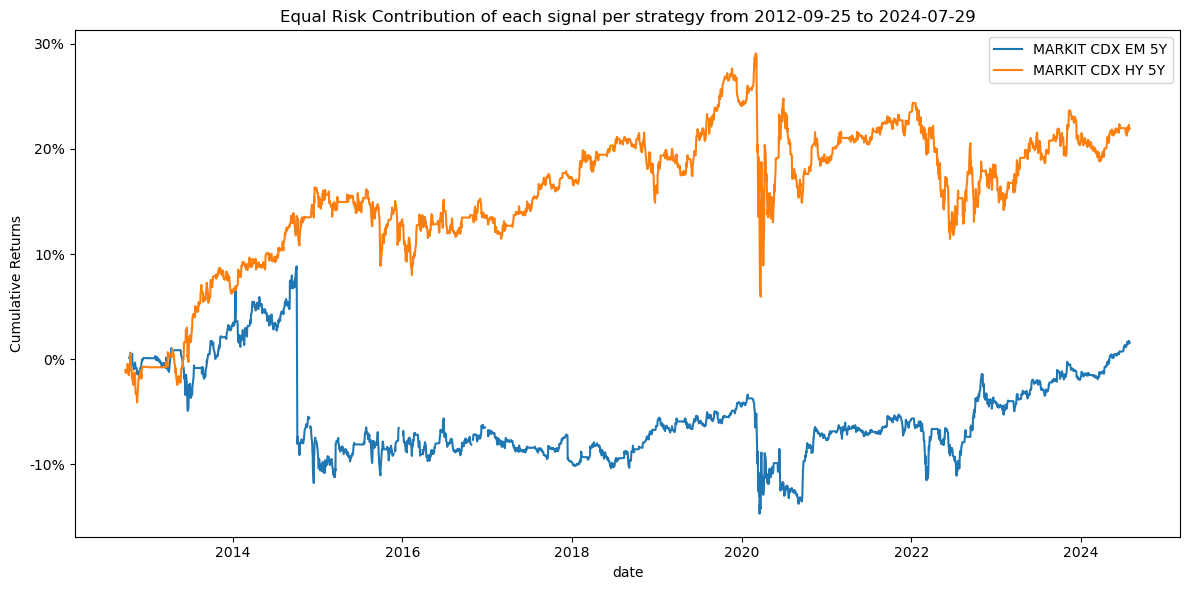

In [18]:
def plot_erc_per_security(df_vol: pd.DataFrame) -> pd.DataFrame: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_vol[
        ["date", "unique_name", "inv_vol"]].
        groupby(["date", "unique_name"]).
        agg("sum").
        reset_index().
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_vol, how = "inner", on = ["date", "unique_name"]).
        assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn)
        [["date", "unique_name", "weighted_rtn"]].
        groupby(["date", "unique_name"]).
        agg("sum").
        reset_index().
        rename(columns = {"unique_name": ""}).
        pivot(index = "date", columns = "", values = "weighted_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes,
            ylabel = "Cumulative Returns",
            title = "Equal Risk Contribution of each signal per strategy from {} to {}".format(
                df_vol.date.min(),
                df_vol.date.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()

plot_erc_per_security(df_vol)

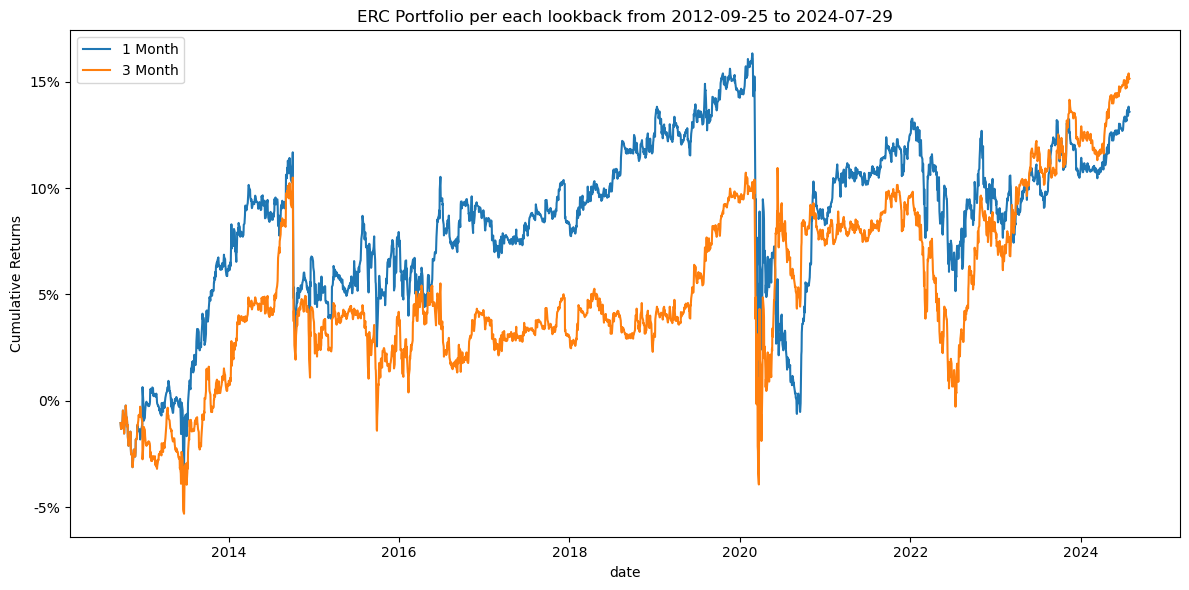

In [19]:
def plot_erc_per_lookback(df_vol: pd.DataFrame) -> pd.DataFrame: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    
    (df_vol[
        ["date", "signal_name", "inv_vol"]].
        groupby(["date", "signal_name"]).
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        reset_index().
        merge(right = df_vol, how = "inner", on = ["date", "signal_name"]).
        assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn)
        [["date", "signal_name", "weighted_rtn"]].
        groupby(["date", "signal_name"]).
        agg("sum").
        reset_index().
        assign(signal_name = lambda x: np.where(x.signal_name == 20, "1 Month", "3 Month")).
        rename(columns = {"signal_name": ""}).
        pivot(index = "date", columns = "", values = "weighted_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            figsize = (12,6),
            ax      = axes,
            ylabel  = "Cumulative Returns",
            title   = "ERC Portfolio per each lookback from {} to {}".format(
                df_vol.date.min(),
                df_vol.date.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()

plot_erc_per_lookback(df_vol)

## Mean Reversion Strategy

In [21]:
def get_mean_reversion_rtn() -> pd.DataFrame:

    df_reversion = (SignalGenerator().get_cds_rtn().drop(
        columns = ["value", "variable"]).
        merge(right = SignalGenerator().get_kalman_zscore_signal(), how = "inner", on = ["date", "unique_name"]).
        drop(columns = ["px_diff", "group_var"]).
        query("variable == 'smooth'").
        assign(signal_rtn = lambda x: 1 * np.sign(x.lag_zscore) * x.px_rtn))

    return df_reversion

df_reversion = get_mean_reversion_rtn()

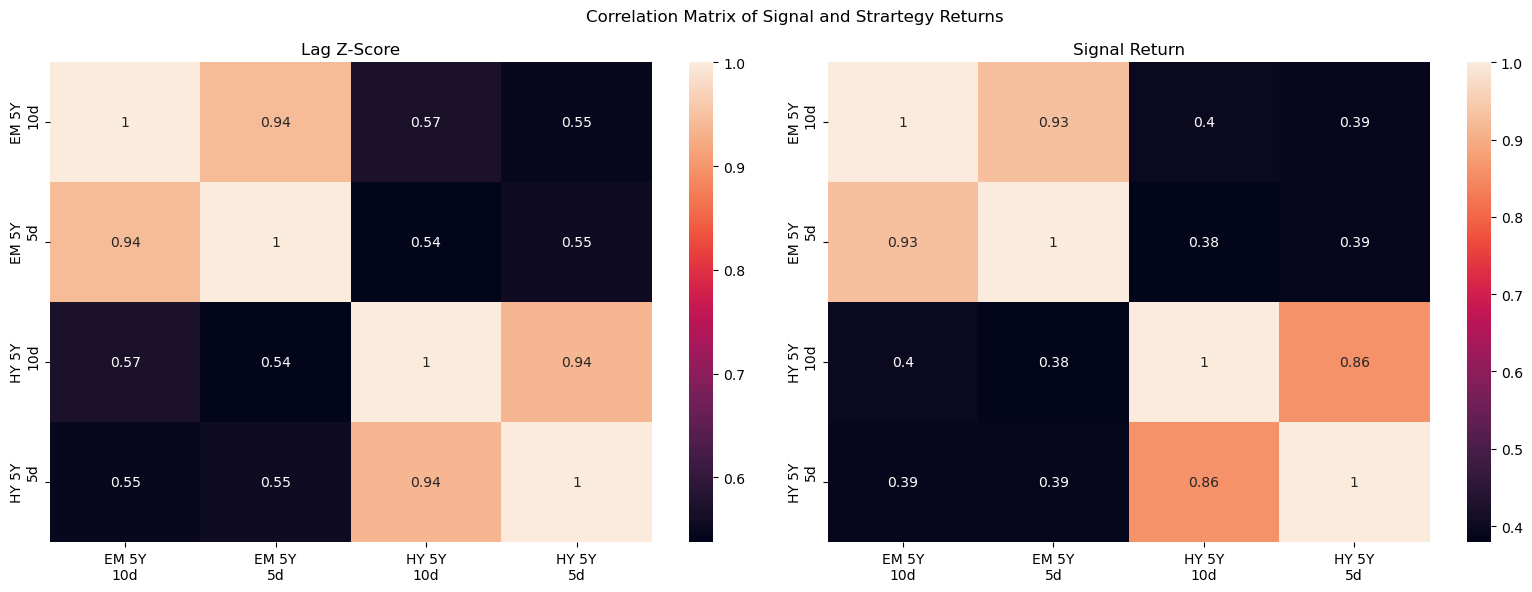

In [22]:
def plot_correlation(df_reversion: pd.DataFrame) -> plt.Figure: 

    df_longer = (df_reversion.assign(
        strat_name = lambda x: x.unique_name.str.split("CDX").str[-1].str.strip() + "\n" + x.lookback.astype(str) + "d")
        [["date", "strat_name", "lag_zscore", "signal_rtn"]].
        melt(id_vars = ["date", "strat_name"]))
    
    variables = df_longer.variable.drop_duplicates().to_list()
    renamer   = {
        "lag_zscore": "Lag Z-Score",
        "signal_rtn": "Signal Return"}
    
    fig, axes = plt.subplots(ncols = len(variables), figsize = (16,6))
    
    for variable, ax in zip(variables, axes.flatten()):
    
        df_corr = (df_longer.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            pivot(index = "date", columns = "strat_name", values = "value").
            corr())
    
        sns.heatmap(
            data  = df_corr,
            ax    = ax,
            annot = True)
    
        ax.set_xlabel(""); ax.set_ylabel("")
        ax.set_title(renamer[variable])
    
    fig.suptitle("Correlation Matrix of Signal and Strartegy Returns")
    plt.tight_layout()

plot_correlation(df_reversion)

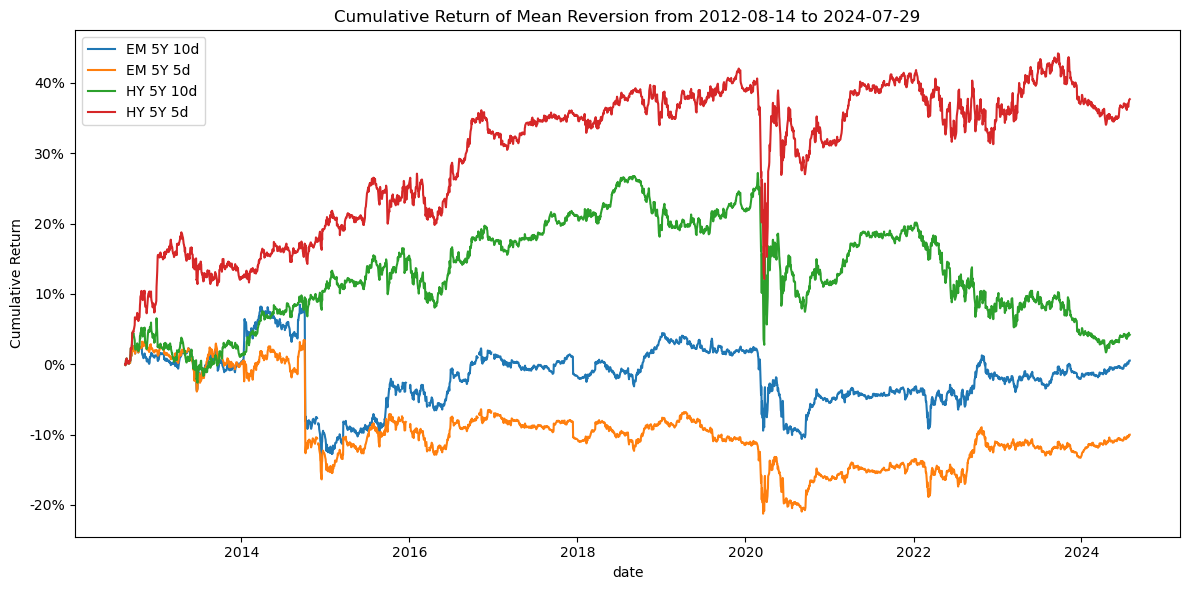

In [23]:
def plot_cumulative_rtn(df_reversion: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_reversion.assign(
        strat_name = lambda x: x.unique_name.str.split("CDX").str[-1].str.strip() + " " + x.lookback.astype(str) + "d")
        [["date", "strat_name", "signal_rtn"]].
        rename(columns = {"strat_name": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            ylabel = "Cumulative Return",
            title  = "Cumulative Return of Mean Reversion from {} to {}".format(
                df_reversion.date.min(),
                df_reversion.date.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    plt.tight_layout()

plot_cumulative_rtn(df_reversion)

In [24]:
def get_sharpe(df_reversion: pd.DataFrame) -> pd.DataFrame: 

    df_original = (SignalGenerator().get_cds_rtn()[
        ["unique_name", "px_rtn"]].
        groupby("unique_name").
        agg(["mean", "std"])
        ["px_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn).
        reset_index()
        [["unique_name", "sharpe"]].
        assign(tmp_name = "No Signal"))
    
    df_strat = (df_reversion[
        ["unique_name", "lookback", "signal_rtn"]].
        groupby(["unique_name", "lookback"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["unique_name", "lookback", "sharpe"]].
        rename(columns = {"lookback": "tmp_name"}))
    
    df_out = pd.concat([df_original, df_strat])
    return df_out

df_sharpe = get_sharpe(df_reversion)

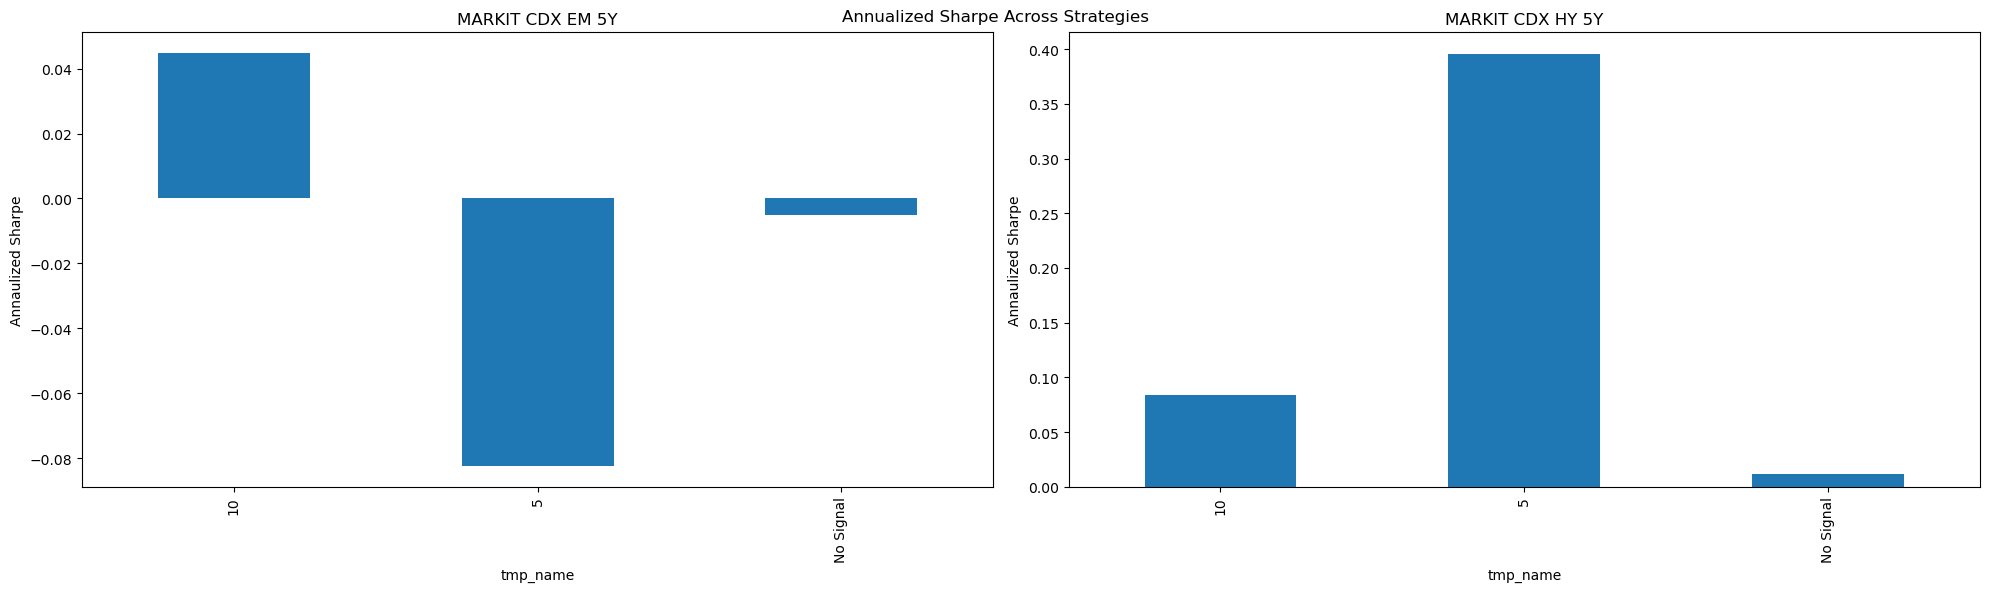

In [61]:
def get_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    group_vars = df_sharpe.unique_name.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))
    
    for group_var, ax in zip(group_vars, axes.flatten()):
    
        (df_sharpe.query(
            "unique_name == @group_var").
            assign(tmp_name = lambda x: x.tmp_name.astype(str)).
            set_index("tmp_name")
            [["sharpe"]].
            sort_index().
            plot(
                ylabel = "Annaulized Sharpe",
                title  = group_var,
                ax     = ax,
                kind   = "bar",
                legend = False))
    
    plt.tight_layout()
    fig.suptitle("Annualized Sharpe Across Strategies")

get_sharpe(df_sharpe)

## Max Rolling Sharpe Optimization